# IBM comparing methods - NMF Pros

In [15]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd 
import numpy as np

# NLP packages
import re
import nltk
import string
import enchant
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline   


from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize


from sklearn.utils import shuffle

In [2]:
df_IBM=pd.read_csv("IBM.csv",encoding = "UTF-8")  #"ISO-8859-1"
#change the order
df_IBM =df_IBM[[ 'Employee ID',
                 'Date',
                 'Location',
                 'Employee Status',
                 'Employee Position',
                 'Overall Rating',
                 'Work Life Balance',
                 'Company Culture',
                 'Career Opportunity',
                 'Benefit and Compensation',
                 'Senior Management',
                 'Helpful Count',
                 'Evaluation',
                 'Overall Comment',
                 'Pros',
                 'Cons',
                 'Advice']]

df_IBM['Company Name'] = df_IBM.apply(lambda _: 'IBM', axis=1)

In [3]:
# create 2 more columns which is combined review & review length
# combined review
df_IBM['CombineReview'] = df_IBM[df_IBM.columns[-3:]].apply(lambda x: ' '.join(x.astype(str).astype(str)), axis=1)
# review length
df_IBM['review length'] = df_IBM['CombineReview'].apply(len)

## New dataframe: matching the employee ID for splitted Pros comments 

In [4]:
IBM_pro_reviews=df_IBM[['Employee ID','Pros', 'Company Name']]
splitted_pros = pd.DataFrame(IBM_pro_reviews.Pros.str.split(r"\.|\,|\+|\?|\!|\;").tolist(), \
                             index=IBM_pro_reviews['Employee ID']).stack()

splitted_pros = splitted_pros.reset_index()[['Employee ID', 0]] 
splitted_pros.columns = ['Employee ID', 'Pros'] 
cleaned_pros=[item for item in splitted_pros.Pros if len(str(item).split())>=2]
splitted_pros=splitted_pros.loc[splitted_pros['Pros'].isin(cleaned_pros)]

#splitted_pros['Company Name'] = splitted_pros.apply(lambda _: 'IBM', axis=1)
splitted_pros.head()

,Employee ID,Pros
0,empReview_17651831,The working culture and environment is good here
1,empReview_17651831,Freedom to employees and facility of work fro...
3,empReview_19452793,Good working environment and opportunity to wo...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...
6,empReview_4852131,But I found this to be fairly pervasive polic...


In [5]:
stop_words=stopwords.words('english')
more_stopwords = """etc nan also some just have from it's /via &amp; that they your there this into would can't"""
stop_words += more_stopwords.split()

In [6]:
pros=["".join(item) for item in splitted_pros.Pros]
pros[0:5]

['The working culture and environment is good here',
 ' Freedom to employees and facility of work from home',
 'Good working environment and opportunity to work different countries',
 "Disclaimer: A lot of what I'm writing below of course depends on the work area and management chain",
 ' But I found this to be fairly pervasive policies in IBM in my 9']

In [7]:
d = enchant.Dict("en_US")    # english dictionary

def text_cleaning(text):
    text=text.lower()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    tokens=nltk.word_tokenize(nopunc)
    tokens=[token for token in tokens if token.isalpha()]
    tokens=[token for token in tokens if token not in stop_words]
    tagged_tokens= nltk.pos_tag(tokens)
        
    words=filter(lambda x: d.check(x), tokens)
    clean_word=[word for word in words if word not in stop_words]
    return clean_word, tagged_tokens 

def taggedwords(review_list):
    packed_words=[]
    for review in review_list:     # use target list for analysis here is cons
        packed_words.append(text_cleaning(review))
        
    review_words,tagged_tokens=zip(*packed_words)
    return tagged_tokens

In [8]:
# obtain tagged_tokens in pros & cons
pros_tagged_tokens=taggedwords(pros)

#cons_tagged_tokens=taggedwords(cons)

In [9]:
# obtain lemmatized reviews
wordnet_lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

pros_lemmatized_words=[] 
for idx, doc in enumerate(pros_tagged_tokens):
    pros_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
len(pros_lemmatized_words)

#cons_lemmatized_words=[] 
#for idx, doc in enumerate(cons_tagged_tokens):
#    cons_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
#len(cons_lemmatized_words)

90161

In [10]:
pros_lemmatized_text=[" ".join(item) for item in pros_lemmatized_words]

# add the lemmatized pros in data frame 
splitted_pros.loc[:,'lemmatized_pros'] = pros_lemmatized_text
splitted_pros.head()

,Employee ID,Pros,lemmatized_pros
0,empReview_17651831,The working culture and environment is good here,working culture environment good
1,empReview_17651831,Freedom to employees and facility of work fro...,freedom employee facility work home
3,empReview_19452793,Good working environment and opportunity to wo...,good work environment opportunity work differe...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...,disclaimer lot im write course depend work are...
6,empReview_4852131,But I found this to be fairly pervasive polic...,find fairly pervasive policy ibm


In [11]:
split_lemma_pros=splitted_pros.loc[splitted_pros['lemmatized_pros'].isin([item for item in splitted_pros.lemmatized_pros if len(str(item).split())>=2])]

split_lemma_pros.head()
len(split_lemma_pros)

,Employee ID,Pros,lemmatized_pros
0,empReview_17651831,The working culture and environment is good here,working culture environment good
1,empReview_17651831,Freedom to employees and facility of work fro...,freedom employee facility work home
3,empReview_19452793,Good working environment and opportunity to wo...,good work environment opportunity work differe...
5,empReview_4852131,Disclaimer: A lot of what I'm writing below of...,disclaimer lot im write course depend work are...
6,empReview_4852131,But I found this to be fairly pervasive polic...,find fairly pervasive policy ibm


87294

In [12]:
# shuffle the data before clustering
pros_lemmatized_text=shuffle(split_lemma_pros)  # dataframe shuffle for later clustering
pros_lemmatized_text.head()

,Employee ID,Pros,lemmatized_pros
96051,empReview_4111476,Good quality of first line,good quality first line
39032,empReview_3268800,ample horizontal opportunities,ample horizontal opportunity
104453,empReview_1681650,Last 19 years have been exciting and fun year...,last year excite fun year great organization
116880,empReview_10618441,man arbeitet immer mit super guten und intere...,man arbeitet immer mit super guten und interes...
96322,empReview_4037632,As someone with a family,someone family


## 1st time NMF topic modeling (20 topics)

In [13]:
# NMF is able to use tf-idf, where LDA only work for the count. 
tfidf_vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2),stop_words=stop_words)
pro_tfidf = tfidf_vectorizer.fit_transform(pros_lemmatized_text.lemmatized_pros)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print(tfidf_feature_names[0:10])
print(pro_tfidf.shape)

#X_train, X_test = train_test_split(pro_tfidf, test_size=0.1, random_state=0)

no_topics = 20

nmf = NMF(n_components=no_topics, \
          random_state=1, alpha=0.01, \
          init='nndsvd').fit(pro_tfidf)

['ability', 'ability change', 'ability get', 'ability grow', 'ability learn', 'ability move', 'ability telecommute', 'ability travel', 'ability work', 'able']
(87294, 5615)


In [14]:
num_top_words=20
for topic_idx, topic in enumerate(nmf.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tfidf_feature_names[i],topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('life', 4.03097942425011), ('work life', 3.939172367885524), ('life balance', 3.7726857382340864), ('balance', 3.4258770136165317), ('work', 2.290898451192122), ('good work', 1.1586693458902628), ('balance good', 0.34262524522569693), ('great work', 0.2609969706138936), ('balance work', 0.13119259065507224), ('balance great', 0.0711942274978185), ('excellent work', 0.06639480978180519), ('personal', 0.05483788208636366), ('personal life', 0.05440640744663689), ('excellent', 0.05216196184761258), ('balance ibm', 0.04542350291704125), ('work balance', 0.03626996706969194), ('well', 0.0336050612419094), ('balance flexibility', 0.03309035797883797), ('maintain', 0.03223515172744829), ('life work', 0.030683747689671123)]


Topic 1:
[('home', 3.525497713224411), ('work home', 3.471850031810003), ('work', 2.182741402300998), ('option', 0.37073616859278136), ('home option', 0.33269584638738314), ('ability work', 0.20913023093528813), ('ability', 0.19439940031058958), ('home facility

### Conclusion after 1st NMF 

- not clear clutsers: 2, 13,16
- 0,9: work-life
- 1,8,15: flexiblility
- 3,6,16,17: people
- 4: work environment
- 5,10,19: company brand
- 7,14: opportunity
- 11: benefit 
- 12: culture
- 18: technology 

In [19]:
# assign topic with highest probability as topics matrix using argmax(axis=1)

topic_assign=nmf.transform(pro_tfidf)

# after normalize to assign the topic in each document
topics=normalize(np.copy(topic_assign), axis=1, norm='l1')
pro_topics =topics.argmax(axis=1)
pro_topics=pro_topics.tolist()

### after 1st round NMF test

In [20]:
# after kmeans' results
test=pd.DataFrame(list(zip(pros_lemmatized_text.lemmatized_pros,\
                           list(pro_topics),\
                           pros_lemmatized_text['Employee ID'])), columns=['pro_text','pro_label','Employee ID']) 
test.head()

,pro_text,pro_label,Employee ID
0,good quality first line,2,empReview_4111476
1,ample horizontal opportunity,7,empReview_3268800
2,last year excite fun year great organization,6,empReview_1681650
3,man arbeitet immer mit super guten und interes...,17,empReview_10618441
4,someone family,13,empReview_4037632


<Container object of 20 artists>

Text(0.5,0,'Topics')

Text(0,0.5,'# of reviews')

Text(0.5,1,'1st Round NMF results')

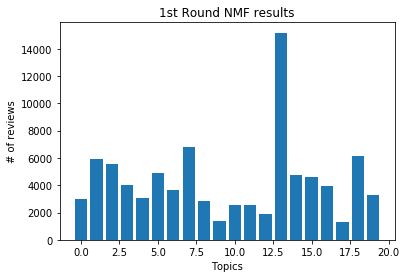

In [21]:
NMF1_distribution=pd.DataFrame(test.groupby(['pro_label'])['pro_label'].count())
NMF1_distribution.index=range(0,20)  
#cluster1_distribution
plt.bar(NMF1_distribution.index,NMF1_distribution.pro_label)
plt.xlabel('Topics')
plt.ylabel('# of reviews')
plt.title('1st Round NMF results') 

## re NMF un-clear topics

In [22]:
# select unclear topics and recombine into new data frame
# drop the pro-label for later to create new labels
re_NMF1=test.loc[test['pro_label'].isin([2,13,16])]
len(re_NMF1)

re_NMF1=re_NMF1.drop(columns=['pro_label'])
re_NMF1=shuffle(re_NMF1)
re_NMF1.head()

24692

,pro_text,Employee ID
63812,saw morale employee go hill every year,empReview_7094817
23429,good atmosphere,empReview_2033982
67955,give training youre bench,empReview_6959404
9541,ibms train program highly regard industry,empReview_15632935
30131,offer tuition reimbursement advance education ...,empReview_110873


In [27]:
# NMF is able to use tf-idf, where LDA only work for the count. 
tfidf_vectorizer_1 = TfidfVectorizer(min_df=4,ngram_range=(1,2),stop_words=stop_words)
pro_tfidf_1 = tfidf_vectorizer_1.fit_transform(re_NMF1.pro_text)
tfidf_feature_names_1 = tfidf_vectorizer_1.get_feature_names()
print(tfidf_feature_names_1[0:10])
print(pro_tfidf_1.shape)


no_topics = 8

re_nmf = NMF(n_components=no_topics, \
          random_state=1, alpha=0.01, \
          init='nndsvd').fit(pro_tfidf_1)

['ability', 'ability change', 'ability deliver', 'ability make', 'ability move', 'ability telecommute', 'ability work', 'able', 'able get', 'able move']
(24692, 5349)


In [28]:
# assign topic with highest probability as topics matrix using argmax(axis=1)

topic_assign1=re_nmf.transform(pro_tfidf_1)

# after normalize to assign the topic in each document
topics_1=normalize(np.copy(topic_assign1), axis=1, norm='l1')
   # high precision, high threshold
re_pro_topics =topics_1.argmax(axis=1)
re_pro_topics=re_pro_topics.tolist()
print(re_pro_topics[0:5])

[7, 0, 7, 7, 1]


In [29]:
num_top_words=20
for topic_idx, topic in enumerate(re_nmf.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tfidf_feature_names[i],topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('functional', 4.682432443675504), ('good network', 0.5377556923865571), ('vacation day', 0.4157132288557297), ('team building', 0.356452116560964), ('every one', 0.3522149390309147), ('good long', 0.3339711217097812), ('get job', 0.2968256188022563), ('good entry', 0.2832693187319954), ('phone', 0.2820931519351158), ('quality people', 0.2803947372097495), ('lot intern', 0.24941494651531607), ('good compare', 0.2341289380654121), ('large enterprise', 0.23277862890632406), ('global', 0.2145022549071161), ('global exposure', 0.1826343132258456), ('liberty', 0.16603008393130142), ('library', 0.16603008393130142), ('goal', 0.1497505818295155), ('global experience', 0.14835305598434453), ('company brand', 0.14721127270641746)]


Topic 1:
[('hawaii', 3.095313129232761), ('vacation day', 2.063075099011698), ('various technology', 1.3796414694930004), ('come office', 0.5467799246871725), ('good network', 0.4712477074504169), ('well establish', 0.4676636061687569), ('believe', 0.41460

In [30]:
# after kmeans' results
test1=pd.DataFrame(list(zip(re_NMF1.pro_text,\
                           list(re_pro_topics),\
                           re_NMF1['Employee ID'])), columns=['pro_text','pro_label','Employee ID']) 
test1.head()
len(test1)

,pro_text,pro_label,Employee ID
0,saw morale employee go hill every year,7,empReview_7094817
1,good atmosphere,0,empReview_2033982
2,give training youre bench,7,empReview_6959404
3,ibms train program highly regard industry,7,empReview_15632935
4,offer tuition reimbursement advance education ...,1,empReview_110873


24692

<Container object of 8 artists>

Text(0.5,0,'Topics')

Text(0,0.5,'# of reviews')

Text(0.5,1,'1st Round NMF results')

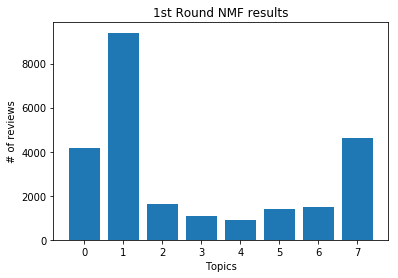

In [31]:
NMF1_distribution=pd.DataFrame(test1.groupby(['pro_label'])['pro_label'].count())
NMF1_distribution.index=range(0,8)  
#cluster1_distribution
plt.bar(NMF1_distribution.index,NMF1_distribution.pro_label)
plt.xlabel('Topics')
plt.ylabel('# of reviews')
plt.title('1st Round NMF results') 

### Conclusion after 1st NMF 

- not clear clutsers: 2,13,16
- 0,9: work-life
- 1,8,15: flexiblility
- 3,6,17: people
- 4: work environment
- 5,10,19: company brand
- 7,14: opportunity
- 11: benefit 
- 12: culture
- 18: technology 

In [34]:
topics_1_NMF=test.loc[test['pro_label'].isin([0,9,1,8,15,3,6,17,4,5,10,19,7,14,11,12,18])]

topics_1_NMF['pro_cluster'] = topics_1_NMF['pro_label'].\
replace([0,9,1,8,15,3,6,17,4,5,10,19,7,14,11,12,18],\
        ['work-life','work-life','flexiblility','flexiblility','flexiblility',\
         'people','people','people',\
         'work environment','company brand', 'company brand','company brand',\
         'opportunity','opportunity',\
         'benefit','culture','technology'])

topics_1_NMF=topics_1_NMF.drop(columns=['pro_label'])
topics_1_NMF.head()
len(topics_1_NMF)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,pro_text,Employee ID,pro_cluster
1,ample horizontal opportunity,empReview_3268800,opportunity
2,last year excite fun year great organization,empReview_1681650,people
3,man arbeitet immer mit super guten und interes...,empReview_10618441,people
5,flexible work cultureloads trainingno pressure...,empReview_6351145,flexiblility
6,lot change happen within spectrum,empReview_17240899,opportunity


62602

In [35]:
# after 1st re-NMF, all unclear topics
NMF2=test1
len(NMF2)

NMF2['pro_cluster'] = NMF2.apply(lambda _: 'unsplit', axis=1)

NMF2=NMF2.drop(columns=['pro_label'])
NMF2[0:15]

24692

,pro_text,Employee ID,pro_cluster
0,saw morale employee go hill every year,empReview_7094817,unsplit
1,good atmosphere,empReview_2033982,unsplit
2,give training youre bench,empReview_6959404,unsplit
3,ibms train program highly regard industry,empReview_15632935,unsplit
4,offer tuition reimbursement advance education ...,empReview_110873,unsplit
5,good health insurance benefitsfamily work life...,empReview_1047189,unsplit
6,nice people good salary,empReview_2068406,unsplit
7,manager provide good training help grow within...,empReview_10575316,unsplit
8,look forward amazing future ibm,empReview_15063361,unsplit
9,ibm employee focus organization,empReview_14396003,unsplit


In [36]:
IBM_row_merged_pros = pd.concat([topics_1_NMF,NMF2], ignore_index=True)
len(IBM_row_merged_pros)
IBM_row_merged_pros.to_csv('Pros_IBM_NMF.csv')

87294